<a href="https://colab.research.google.com/github/mspsullivan/poisonml/blob/main/data_poisoning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Top threats part 2: Data Poisoning
## cloned from ART - Adversarial Patch - TensorFlow v2
## Initialization 1: Import Python packages

In [1]:
!pip install git+https://github.com/nottombrown/imagenet_stubs
!pip install adversarial-robustness-toolbox
!pip install tensorflow_addons

import warnings
warnings.filterwarnings('ignore')

import random
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]
import imagenet_stubs
from imagenet_stubs.imagenet_2012_labels import name_to_label

import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image

from art.estimators.classification import TensorFlowV2Classifier, EnsembleClassifier
from art.attacks.evasion import AdversarialPatch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/nottombrown/imagenet_stubs to /tmp/pip-req-build-bg7zgc6j
  Running command git clone --filter=blob:none --quiet https://github.com/nottombrown/imagenet_stubs /tmp/pip-req-build-bg7zgc6j
  Resolved https://github.com/nottombrown/imagenet_stubs to commit 0b501276f54cbf45b8e1b67dccbdcbe51de88365
  Preparing metadata (setup.py) ... done
  Created wheel for imagenet-stubs: filename=imagenet_stubs-0.0.7-py3-none-any.whl size=794840 sha256=caaa0f5791234d873a45de9116bebe1d78e268e5917a65c6a522f71c73029e14
  Stored in directory: /tmp/pip-ephem-wheel-cache-nzh6ac_b/wheels/48/52/bf/2bca833fe1e709dbd0a32a322e7dda02cd17c6c8ebf5127949
Successfully built imagenet-stubs
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 12.3 MB/s eta 0:00:00
Looking in indexes: https://pyp

# Initialization 2: Configure model settings

In [2]:
target_name = 'toaster'
image_shape = (224, 224, 3)
clip_values = (0, 255)
nb_classes  =1000
batch_size = 16
scale_min = 0.4
scale_max = 1.0
rotation_max = 22.5
learning_rate = 5000.
max_iter = 500

# Model Engineering 1: Load algorithm

In [3]:
model = tf.keras.applications.resnet50.ResNet50(weights="imagenet")

mean_b = 103.939
mean_g = 116.779
mean_r = 123.680

tfc = TensorFlowV2Classifier(model=model, loss_object=None, train_step=None, nb_classes=nb_classes,
                             input_shape=image_shape, clip_values=clip_values, 
                             preprocessing=([mean_b, mean_g, mean_r], np.array([1.0, 1.0, 1.0])))

102967424/102967424 [==============================] - 5s 0us/step


# Data engineering 1: Load images from source data

In [4]:
images_list = list()

for image_path in imagenet_stubs.get_image_paths():
    im = image.load_img(image_path, target_size=(224, 224))
    im = image.img_to_array(im)
    im = im[:, :, ::-1].astype(np.float32) # RGB to BGR
    im = np.expand_dims(im, axis=0)
    images_list.append(im)

images = np.vstack(images_list)

In [5]:
def bgr_to_rgb(x):
    return x[:, :, ::-1]

# Attack 1: Generate adversarial patch 

In [19]:
ap = AdversarialPatch(classifier=tfc, rotation_max=rotation_max, scale_min=scale_min, scale_max=scale_max,
                      learning_rate=learning_rate, max_iter=max_iter, batch_size=batch_size,
                      patch_shape=(224, 224, 3))

label = name_to_label(target_name)
y_one_hot = np.zeros(nb_classes)
y_one_hot[label] = 1.0
y_target = np.tile(y_one_hot, (images.shape[0], 1))

patch, patch_mask = ap.generate(x=images, y=y_target)

Adversarial Patch TensorFlow v2:   0%|          | 0/500 [00:00<?, ?it/s]

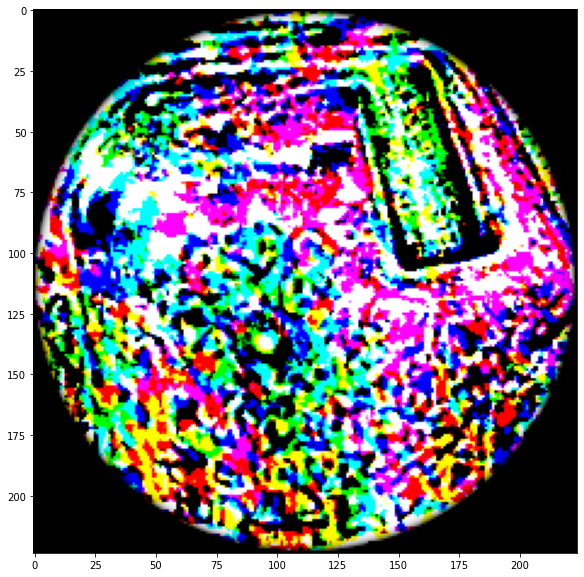

In [20]:
plt.imshow((bgr_to_rgb(patch) * patch_mask).astype(np.uint8))

# Model Engineering 2: Apply algorithm

In [24]:
#patched_images = ap.apply_patch(images, scale=0.25)
#patched_images = ap.apply_patch(images, scale=0.4)
patched_images = ap.apply_patch(images, scale=0.5)

In [22]:
def predict_model(classifier, image):
    plt.imshow(bgr_to_rgb(image.astype(np.uint8)))
    plt.show()
    
    image = np.copy(image)
    image = np.expand_dims(image, axis=0)
    
    prediction = classifier.predict(image)
    
    top = 5
    prediction_decode = decode_predictions(prediction, top=top)[0]
    print('Predictions:')
    
    lengths = list()
    for i in range(top):
        lengths.append(len(prediction_decode[i][1]))
    max_length = max(lengths)
    
    for i in range(top):
        name = prediction_decode[i][1]
        name = name.ljust(max_length, " ")
        probability = prediction_decode[i][2]
        output_str = "{} {:.6f}".format(name, probability)
        print(output_str)

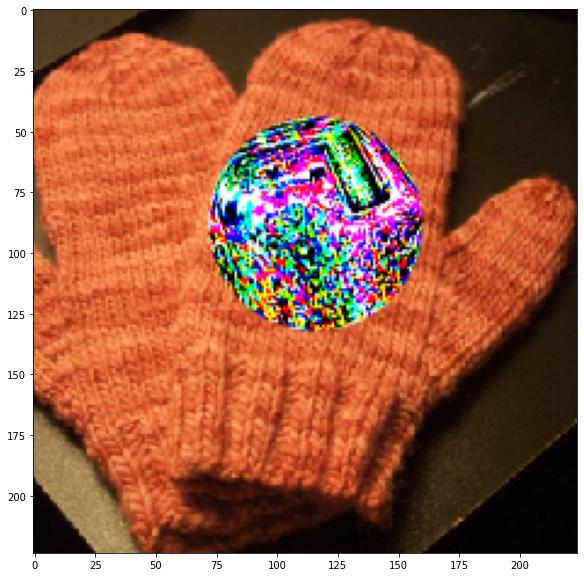

Predictions:
toaster    0.655840
mitten     0.124409
bonnet     0.101044
piggy_bank 0.080361
sock       0.014498


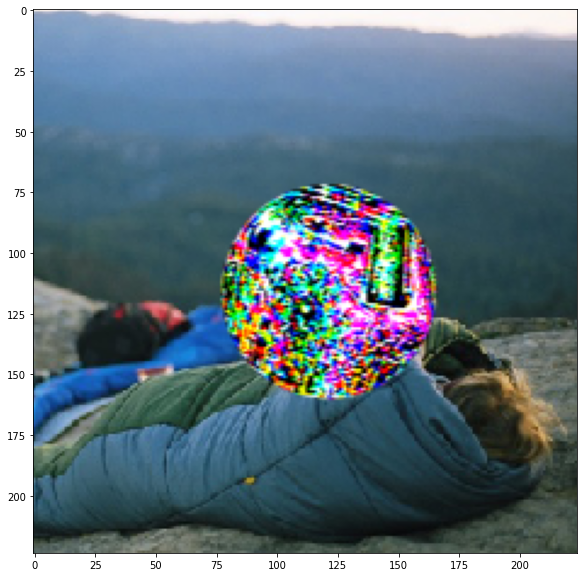

Predictions:
toaster      0.944063
piggy_bank   0.014303
parachute    0.013847
balloon      0.010803
sleeping_bag 0.004022


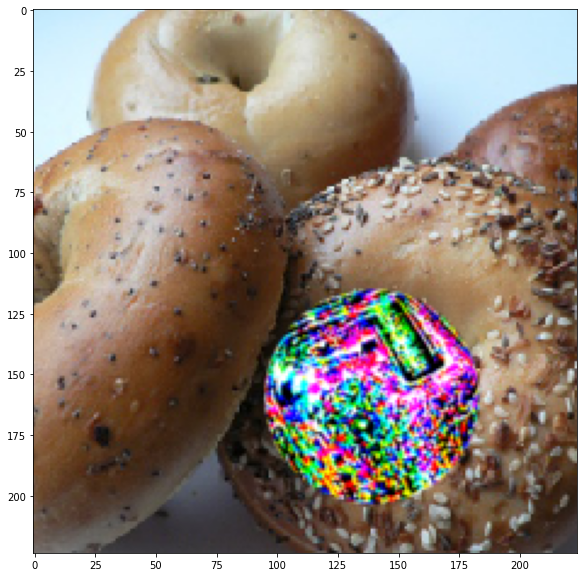

Predictions:
bagel      0.985448
toaster    0.014382
pretzel    0.000105
piggy_bank 0.000025
bakery     0.000010


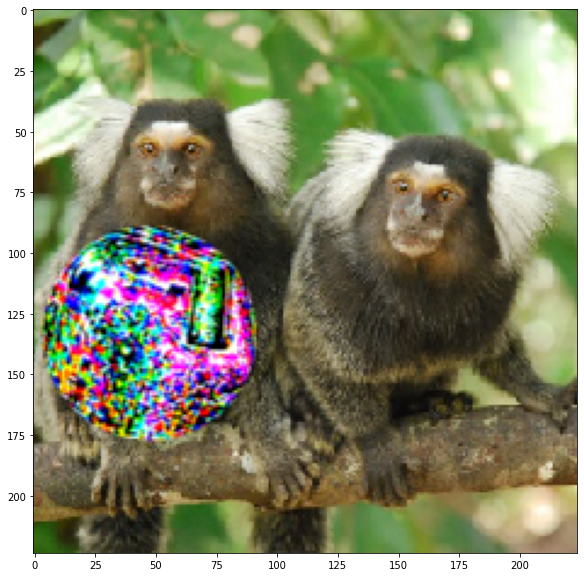

Predictions:
marmoset 0.658299
titi     0.341338
langur   0.000196
capuchin 0.000074
gibbon   0.000020


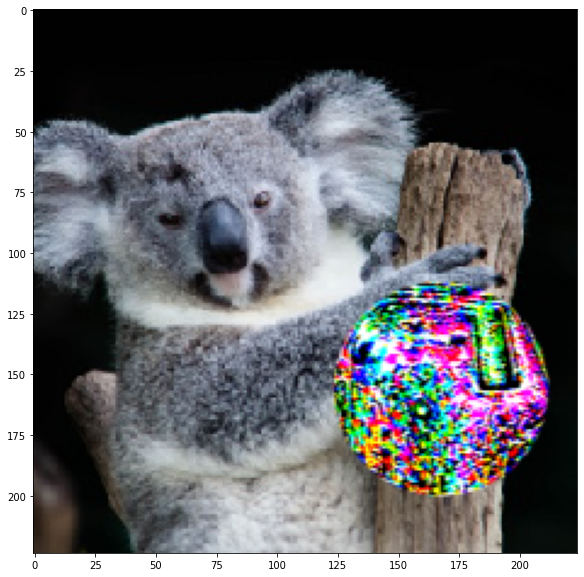

Predictions:
toaster          0.943888
koala            0.022798
piggy_bank       0.009463
padlock          0.008269
pencil_sharpener 0.001507


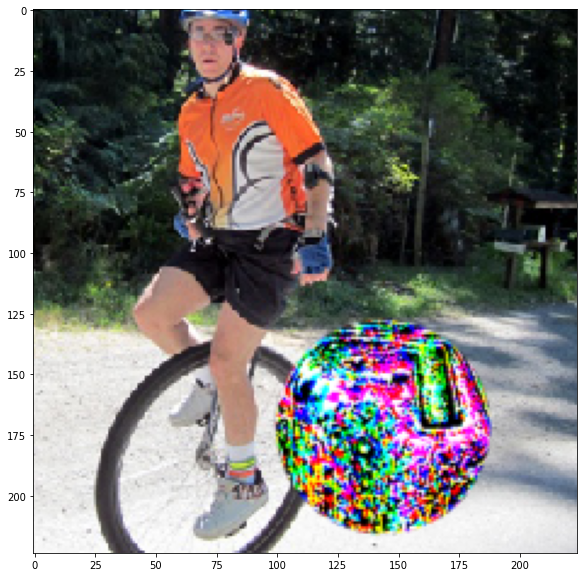

Predictions:
crash_helmet          0.405310
mountain_bike         0.229442
toaster               0.202227
bicycle-built-for-two 0.055514
unicycle              0.046029


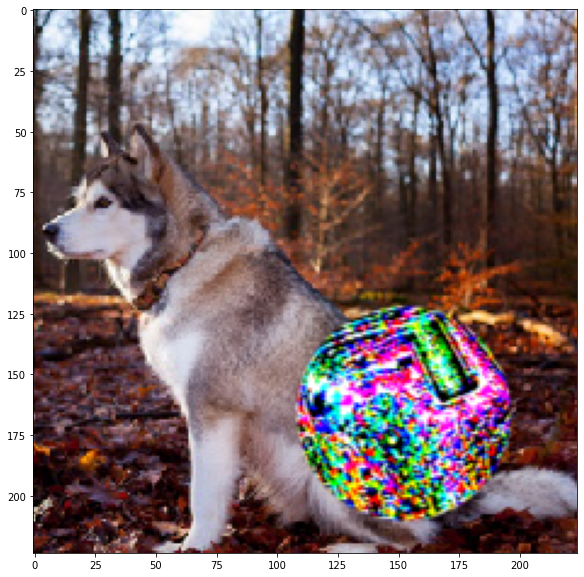

Predictions:
malamute           0.681629
Siberian_husky     0.198722
Eskimo_dog         0.118260
timber_wolf        0.000726
Norwegian_elkhound 0.000338


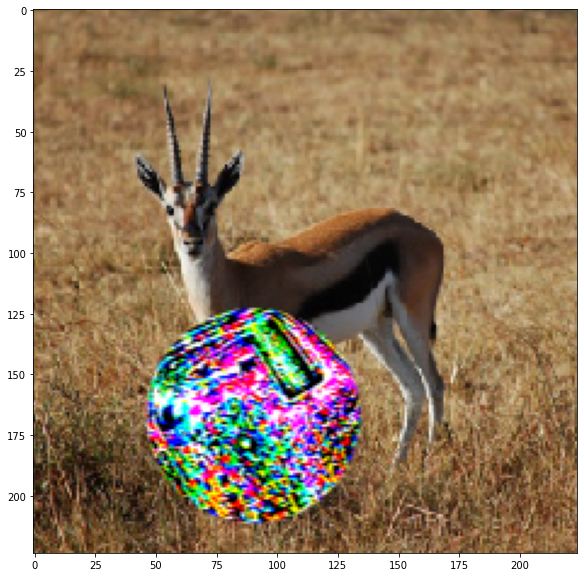

Predictions:
gazelle    0.836012
toaster    0.160543
impala     0.003012
piggy_bank 0.000201
whippet    0.000045


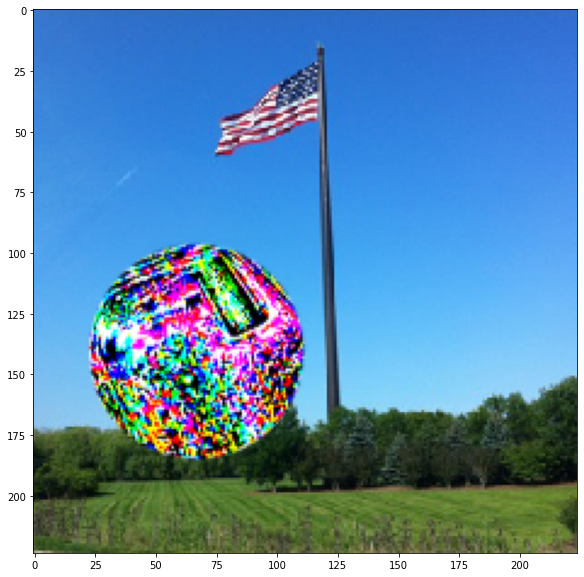

Predictions:
toaster      0.999033
piggy_bank   0.000738
crash_helmet 0.000115
birdhouse    0.000019
ashcan       0.000017


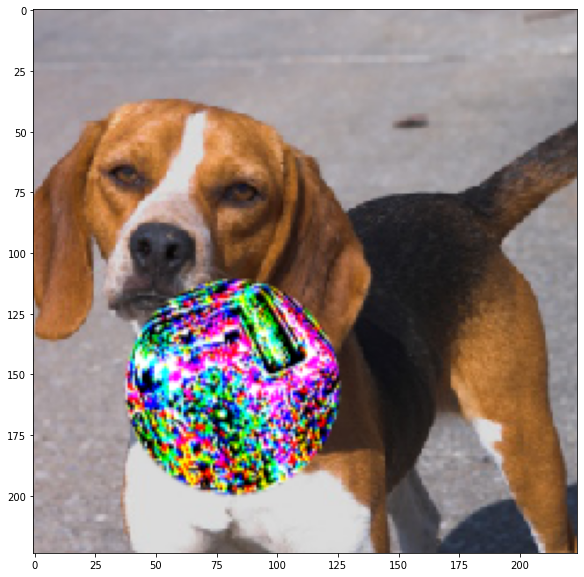

Predictions:
beagle           0.802912
English_foxhound 0.080252
toaster          0.066148
Walker_hound     0.045778
piggy_bank       0.000710


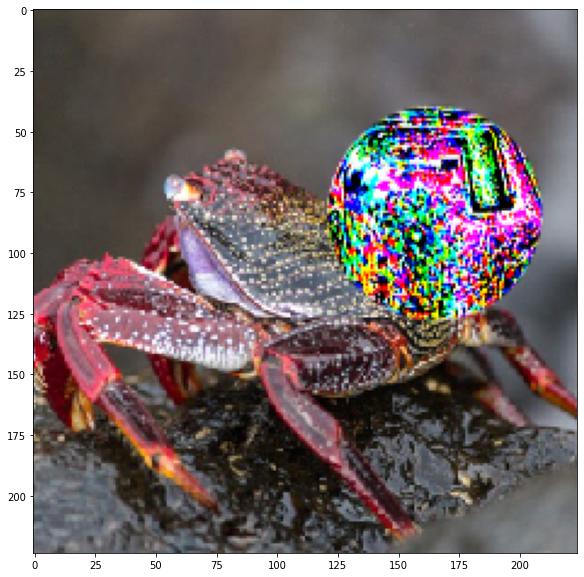

Predictions:
rock_crab    0.989545
fiddler_crab 0.008758
king_crab    0.001278
piggy_bank   0.000221
toaster      0.000075


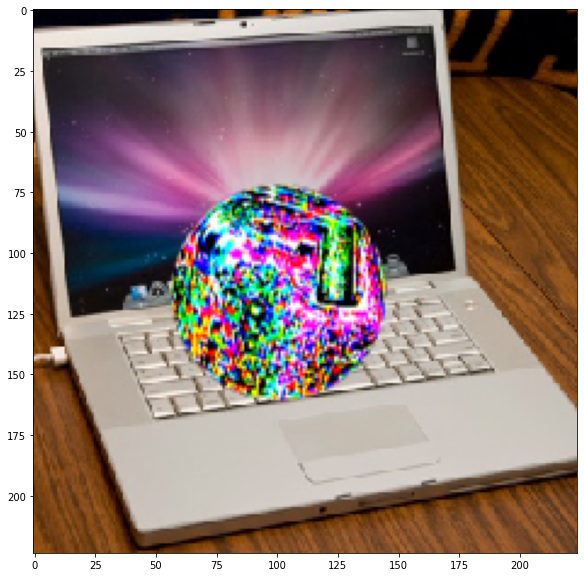

Predictions:
mouse             0.563761
notebook          0.245306
laptop            0.135730
computer_keyboard 0.015006
toaster           0.011870


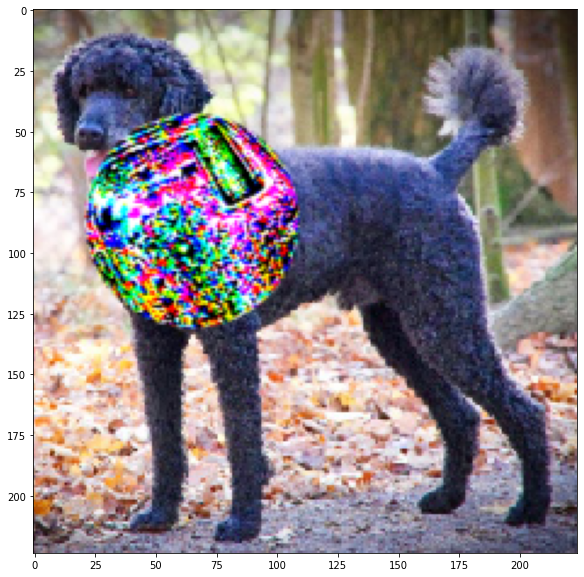

Predictions:
standard_poodle    0.610441
miniature_poodle   0.308440
toy_poodle         0.037633
Kerry_blue_terrier 0.021618
Irish_terrier      0.008918


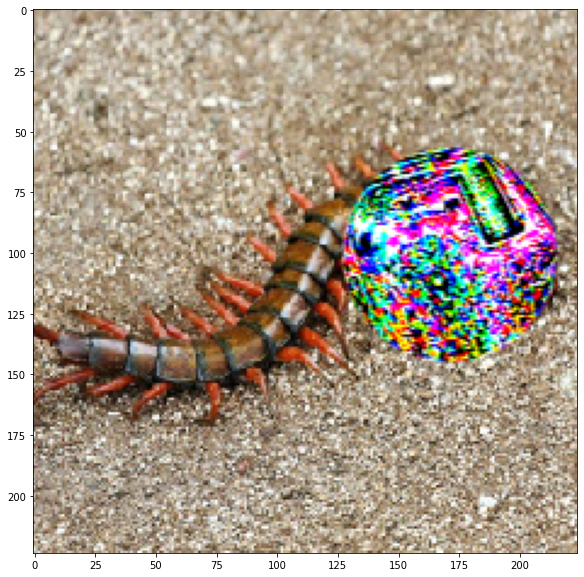

Predictions:
toaster    0.843219
centipede  0.064520
necklace   0.010488
piggy_bank 0.007937
maraca     0.007009


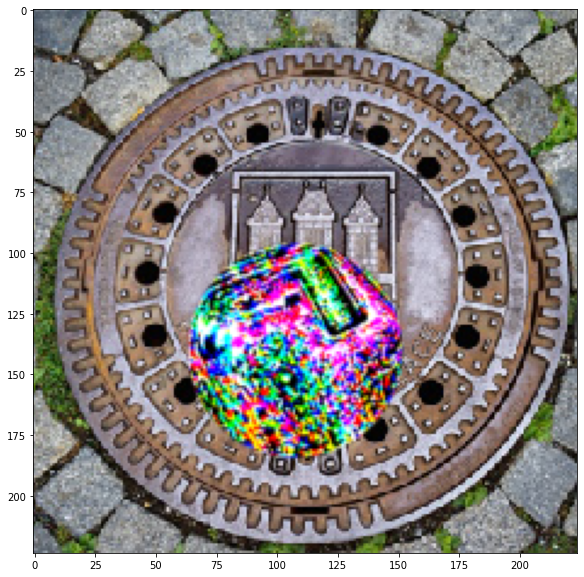

Predictions:
manhole_cover 0.998662
altar         0.000330
ashcan        0.000120
tray          0.000099
birdhouse     0.000078


In [25]:
for i in range(0,15):
   predict_model(tfc, patched_images[i])

In [ ]:
print (patched_images[1])

NameError: ignored